<a href="https://colab.research.google.com/github/otakunoichin/test/blob/main/Ai%E7%B6%B2%E8%86%9Cwhiteadd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, re, glob, random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/AiFundas"

# 既存（元データのパッチが入っている場所）
PATCH_IMGDIR = os.path.join(ROOT, "patches", "images")
PATCH_LBLDIR = os.path.join(ROOT, "patches", "labels")

# 追加データ（白い凝固斑）
ADD_IMG_DIR = os.path.join(ROOT, "addImages")
ADD_LBL_DIR = os.path.join(ROOT, "addLabels")

add_pairs = [
    ("Pt13R_1MAF.jpg", "Pt13R_1MAF.png"),
    ("Pt13R_1YAF.jpg", "Pt13R_1YAF.png"),
]

for im, lb in add_pairs:
    print(im, os.path.exists(os.path.join(ADD_IMG_DIR, im)),
          "|", lb, os.path.exists(os.path.join(ADD_LBL_DIR, lb)))

Mounted at /content/drive
Pt13R_1MAF.jpg True | Pt13R_1MAF.png True
Pt13R_1YAF.jpg True | Pt13R_1YAF.png True


In [2]:
TARGET_SIZE = 4096
PATCH_SIZE  = 512

PATCH_ADD_ROOT = os.path.join(ROOT, "patches_add")
PATCH_ADD_IMGDIR = os.path.join(PATCH_ADD_ROOT, "images")
PATCH_ADD_LBLDIR = os.path.join(PATCH_ADD_ROOT, "labels")
os.makedirs(PATCH_ADD_IMGDIR, exist_ok=True)
os.makedirs(PATCH_ADD_LBLDIR, exist_ok=True)

def load_gray_u8(path):
    return np.array(Image.open(path).convert("L"), dtype=np.uint8)

def reflect_pad_to(arr, target=4096):
    h, w = arr.shape
    if h > target or w > target:
        raise ValueError(f"image too large: {arr.shape} > {target}")
    pad_h = target - h
    pad_w = target - w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    arr_pad = np.pad(arr, ((top, bottom), (left, right)), mode="reflect")
    return arr_pad

def save_gray(arr_u8, path):
    Image.fromarray(arr_u8).save(path)

# 追加パッチ化
total = 0
for img_name, lbl_name in add_pairs:
    img_path = os.path.join(ADD_IMG_DIR, img_name)
    lbl_path = os.path.join(ADD_LBL_DIR, lbl_name)

    img = load_gray_u8(img_path)
    msk = load_gray_u8(lbl_path)

    img_pad = reflect_pad_to(img, TARGET_SIZE)
    msk_pad = reflect_pad_to(msk, TARGET_SIZE)

    # マスクを {0,255} に統一（0/1/255 混在対策）
    msk_pad = ((msk_pad > 0).astype(np.uint8) * 255)

    base_id = os.path.splitext(img_name)[0]  # Pt13R_1MAF

    for r in range(TARGET_SIZE // PATCH_SIZE):
        for c in range(TARGET_SIZE // PATCH_SIZE):
            y0 = r * PATCH_SIZE
            x0 = c * PATCH_SIZE
            img_p = img_pad[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE]
            msk_p = msk_pad[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE]

            out_img = os.path.join(PATCH_ADD_IMGDIR, f"image_{base_id}_r{r}_c{c}.png")
            out_msk = os.path.join(PATCH_ADD_LBLDIR, f"mask_{base_id}_r{r}_c{c}.png")
            save_gray(img_p, out_img)
            save_gray(msk_p, out_msk)
            total += 1

print("added patches:", total)
print("per image:", (TARGET_SIZE//PATCH_SIZE)*(TARGET_SIZE//PATCH_SIZE))

added patches: 128
per image: 64


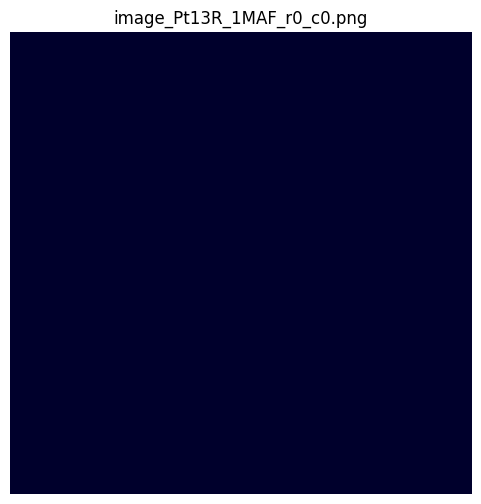

mask unique: [255]


In [3]:
#確認
p = sorted(glob.glob(os.path.join(PATCH_ADD_IMGDIR, "*.png")))[0]
m = p.replace("/images/", "/labels/").replace("image_", "mask_")
img = np.array(Image.open(p).convert("L"))
msk = np.array(Image.open(m).convert("L"))

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.imshow(msk, cmap="jet", alpha=0.35)
plt.title(os.path.basename(p))
plt.axis("off")
plt.show()

print("mask unique:", np.unique(msk)[:10])

In [6]:
# 既存パッチ
base_patch_imgs = sorted(glob.glob(os.path.join(PATCH_IMGDIR, "*.png")))
# 追加パッチ（白）
add_patch_imgs  = sorted(glob.glob(os.path.join(PATCH_ADD_IMGDIR, "*.png")))

print("base patches:", len(base_patch_imgs))
print("add  patches:", len(add_patch_imgs))

def parse_base_id(path):
    # 既存: image_000123_r0_c0.png
    base = os.path.basename(path)
    m = re.match(r"image_(\d+)_r(\d+)_c(\d+)\.png$", base)
    if not m: return None
    return int(m.group(1))

# 既存：画像ID一覧
all_base_ids = sorted({parse_base_id(p) for p in base_patch_imgs if parse_base_id(p) is not None})
print("unique base IDs:", len(all_base_ids), "example:", all_base_ids[:10])

# 既存のID単位 split（前と同じ seed にして再現性確保）
random.seed(42)
ids = all_base_ids[:]
random.shuffle(ids)
val_ratio = 0.2
n_val = max(1, int(len(ids) * val_ratio))
val_ids = set(ids[:n_val])
train_ids = set(ids[n_val:])

# train/valパッチリスト（既存分）
train_img_paths, val_img_paths = [], []
for p in base_patch_imgs:
    i = parse_base_id(p)
    if i in train_ids:
        train_img_paths.append(p)
    elif i in val_ids:
        val_img_paths.append(p)

# ✅ 追加（白）を「何倍も」混ぜる　追加変更　10にします
WHITE_MULT = 10   # まずは 20〜50 で。
train_img_paths += add_patch_imgs * WHITE_MULT

print("train patches:", len(train_img_paths))
print("val patches  :", len(val_img_paths))
print("val IDs:", len(val_ids), "train IDs:", len(train_ids))
#追加変更のところ
print("WHITE_MULT:", WHITE_MULT)

base patches: 2240
add  patches: 128
unique base IDs: 35 example: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
train patches: 3072
val patches  : 448
val IDs: 7 train IDs: 28
WHITE_MULT: 10


In [5]:
import os

print("train total:", len(train_img_paths))
print("val total  :", len(val_img_paths))

# add側パッチが何枚入ってる？
add_count = sum([1 for p in train_img_paths if os.path.abspath(PATCH_ADD_IMGDIR) in os.path.abspath(p)])
base_count = sum([1 for p in train_img_paths if os.path.abspath(PATCH_IMGDIR) in os.path.abspath(p)])

print("base in train:", base_count)
print("add  in train:", add_count)
print("add ratio:", add_count / (len(train_img_paths) + 1e-8))

# add側が0なら混ざってない（ここが最初のチェック）
assert add_count > 0, "addパッチがtrainに入っていません（PATCH_ADD_IMGDIRや追加パッチ生成を再確認）"

train total: 8192
val total  : 448
base in train: 1792
add  in train: 6400
add ratio: 0.7812499999990462


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class PatchSegDataset(Dataset):
    def __init__(self, img_paths, augment=False):
        self.img_paths = img_paths
        self.augment = augment

    def __len__(self):
        return len(self.img_paths)

    def _label_path(self, img_path):
        base = os.path.basename(img_path)
        lbl_base = base.replace("image_", "mask_")
        # base or add のどちらかにある
        cand1 = os.path.join(PATCH_LBLDIR, lbl_base)
        cand2 = os.path.join(PATCH_ADD_LBLDIR, lbl_base)
        if os.path.exists(cand1): return cand1
        if os.path.exists(cand2): return cand2
        raise FileNotFoundError(lbl_base)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        lbl_path = self._label_path(img_path)

        img = np.array(Image.open(img_path).convert("L"), dtype=np.float32) / 255.0
        msk = (np.array(Image.open(lbl_path).convert("L"), dtype=np.uint8) > 0).astype(np.float32)

        if self.augment:
            if random.random() < 0.5:
                img = np.fliplr(img).copy(); msk = np.fliplr(msk).copy()
            if random.random() < 0.5:
                img = np.flipud(img).copy(); msk = np.flipud(msk).copy()
            k = random.randint(0, 3)
            if k:
                img = np.rot90(img, k).copy(); msk = np.rot90(msk, k).copy()

            # 追加：白への頑健性を上げる輝度変換
            if random.random() < 0.7:
              gamma = random.uniform(0.6, 1.6)
              img = np.clip(img ** gamma, 0, 1)

            if random.random() < 0.7:
              gain = random.uniform(0.8, 1.4)
              bias = random.uniform(-0.05, 0.05)
              img = np.clip(img * gain + bias, 0, 1)

        img_t = torch.from_numpy(img).unsqueeze(0)  # 1,H,W
        msk_t = torch.from_numpy(msk).unsqueeze(0)  # 1,H,W
        return img_t, msk_t

train_ds = PatchSegDataset(train_img_paths, augment=True)
val_ds   = PatchSegDataset(val_img_paths, augment=False)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

xb, yb = next(iter(train_loader))
print("x:", xb.shape, xb.min().item(), xb.max().item())
print("y unique:", torch.unique(yb))

x: torch.Size([8, 1, 512, 512]) 0.0 1.0
y unique: tensor([0., 1.])


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base);    self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base, base*2);   self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base*2, base*4); self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(base*4, base*8); self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base*8, base*16)

        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2); self.dec4 = DoubleConv(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8,  base*4, 2, stride=2); self.dec3 = DoubleConv(base*8,  base*4)
        self.up2 = nn.ConvTranspose2d(base*4,  base*2, 2, stride=2); self.dec2 = DoubleConv(base*4,  base*2)
        self.up1 = nn.ConvTranspose2d(base*2,  base,   2, stride=2); self.dec1 = DoubleConv(base*2,  base)

        self.outc = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b  = self.bottleneck(self.pool4(e4))

        d4 = self.up4(b); d4 = torch.cat([d4, e4], dim=1); d4 = self.dec4(d4)
        d3 = self.up3(d4); d3 = torch.cat([d3, e3], dim=1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2, e2], dim=1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1, e1], dim=1); d1 = self.dec1(d1)

        return self.outc(d1)

In [9]:
import torch
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

old_ckpt_path = os.path.join(ROOT, "best_unet.pt")
new_ckpt_path = os.path.join(ROOT, "best_unet_with_white.pt")  # ★上書き防止の新名

model = UNet(in_ch=1, out_ch=1, base=32).to(device)

# 既存重みをロード（初期値にする）
ckpt = torch.load(old_ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"], strict=True)
print("loaded old weights from:", old_ckpt_path)

# 追加学習は少し小さめLRがおすすめ lrの値修正調整します
optimizer = Adam(model.parameters(), lr=5e-5)
bce = nn.BCEWithLogitsLoss()

def dice_loss_from_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2*(probs*targets).sum(dim=(2,3)) + eps
    den = (probs+targets).sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()

@torch.no_grad()
def dice_score_from_logits(logits, targets, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    pred = (probs > thr).float()
    num = 2*(pred*targets).sum(dim=(2,3)) + eps
    den = (pred+targets).sum(dim=(2,3)) + eps
    return (num/den).mean().item()

def loss_fn(logits, targets):
    return bce(logits, targets) + dice_loss_from_logits(logits, targets)

loaded old weights from: /content/drive/MyDrive/AiFundas/best_unet.pt


Epoch 01 | train loss 0.2676 dice 0.9487 | val loss 0.1857 dice 0.9638
  saved best -> /content/drive/MyDrive/AiFundas/best_unet_with_white.pt
Epoch 02 | train loss 0.2622 dice 0.9501 | val loss 0.1797 dice 0.9653
  saved best -> /content/drive/MyDrive/AiFundas/best_unet_with_white.pt
Epoch 03 | train loss 0.2527 dice 0.9511 | val loss 0.1816 dice 0.9641
Epoch 04 | train loss 0.2493 dice 0.9517 | val loss 0.1750 dice 0.9659
  saved best -> /content/drive/MyDrive/AiFundas/best_unet_with_white.pt
Epoch 05 | train loss 0.2470 dice 0.9523 | val loss 0.1712 dice 0.9660
  saved best -> /content/drive/MyDrive/AiFundas/best_unet_with_white.pt


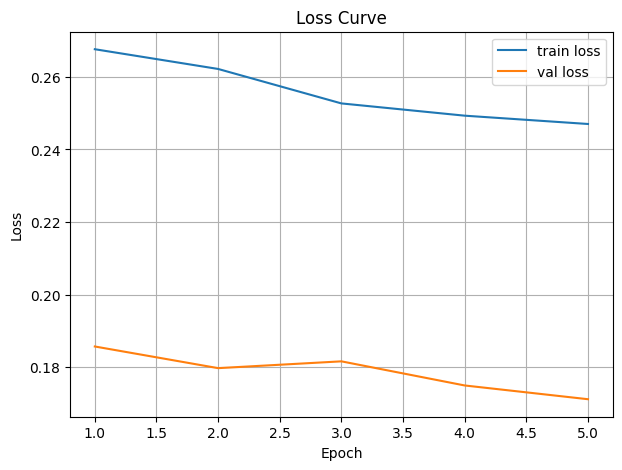

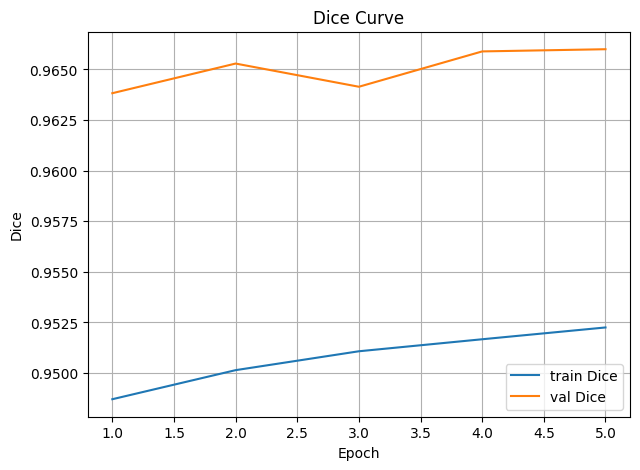

DONE. new model saved at: /content/drive/MyDrive/AiFundas/best_unet_with_white.pt


In [10]:
def run_one_epoch(model, loader, train=True):
    model.train(train)
    total_loss, total_dice, n = 0.0, 0.0, 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = loss_fn(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_dice += dice_score_from_logits(logits, y) * x.size(0)
        n += x.size(0)

    return total_loss / n, total_dice / n

train_losses, val_losses, train_dices, val_dices = [], [], [], []
best_val = -1

EPOCHS = 5  # 追加2枚なのでまずは短く（必要なら10に上げてOK）
for ep in range(1, EPOCHS+1):
    tr_loss, tr_dice = run_one_epoch(model, train_loader, train=True)
    va_loss, va_dice = run_one_epoch(model, val_loader, train=False)

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_dices.append(tr_dice);  val_dices.append(va_dice)

    print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} dice {tr_dice:.4f} | val loss {va_loss:.4f} dice {va_dice:.4f}")

    if va_dice > best_val:
        best_val = va_dice
        torch.save({"model": model.state_dict(), "epoch": ep, "val_dice": va_dice}, new_ckpt_path)
        print("  saved best ->", new_ckpt_path)

# 学習曲線
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_losses, label="train loss")
plt.plot(epochs, val_losses, label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.plot(epochs, train_dices, label="train Dice")
plt.plot(epochs, val_dices, label="val Dice")
plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.title("Dice Curve")
plt.legend(); plt.grid(True); plt.show()

print("DONE. new model saved at:", new_ckpt_path)

loaded new best epoch: 5 val_dice: 0.9660011976957321
Pt13R_1MAF.jpg pred_area: 15997017 gt_area: 14722754


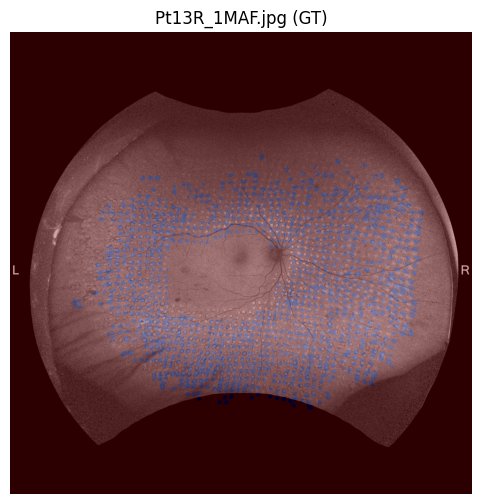

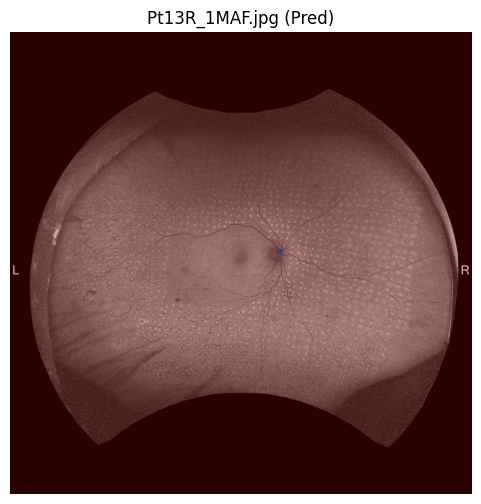

Pt13R_1YAF.jpg pred_area: 15634050 gt_area: 14278743


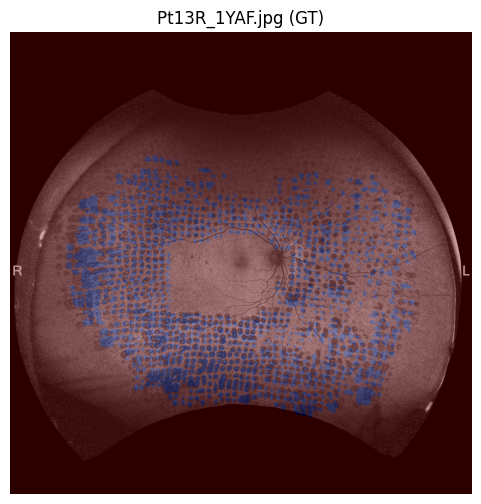

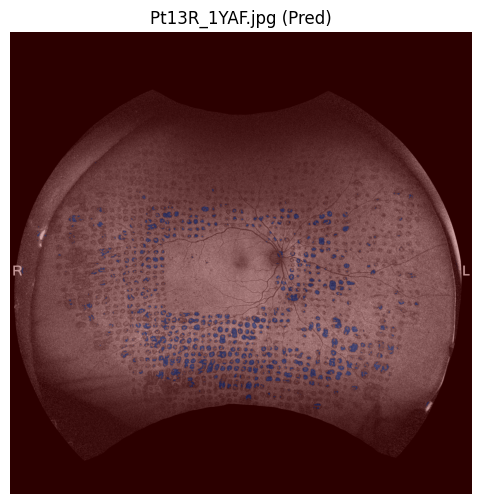

In [13]:
# 新モデルをロード（最良epoch）
best = torch.load(new_ckpt_path, map_location=device)
model.load_state_dict(best["model"])
model.eval()
print("loaded new best epoch:", best.get("epoch"), "val_dice:", best.get("val_dice"))

def predict_mask_from_image(gray_u8, thr=0.2):
    # 4096反射pad→512パッチ（推論）
    def reflect_pad_to(arr, target=4096):
        h, w = arr.shape
        pad_h = target - h; pad_w = target - w
        top = pad_h//2; bottom = pad_h-top
        left = pad_w//2; right = pad_w-left
        arr_pad = np.pad(arr, ((top,bottom),(left,right)), mode="reflect")
        return arr_pad, (top,left,h,w)

    H, W = gray_u8.shape
    img_pad, (top,left,h,w) = reflect_pad_to(gray_u8, TARGET_SIZE)

    prob_canvas = np.zeros((TARGET_SIZE, TARGET_SIZE), dtype=np.float32)

    with torch.no_grad():
        for r in range(TARGET_SIZE // PATCH_SIZE):
            for c in range(TARGET_SIZE // PATCH_SIZE):
                y0 = r*PATCH_SIZE; x0 = c*PATCH_SIZE
                patch = img_pad[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE].astype(np.float32)/255.0
                x = torch.from_numpy(patch).unsqueeze(0).unsqueeze(0).to(device)
                logits = model(x)
                prob = torch.sigmoid(logits).squeeze().cpu().numpy()
                prob_canvas[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE] = prob

    prob_crop = prob_canvas[top:top+h, left:left+w]
    mask01 = (prob_crop > thr).astype(np.uint8)
    return prob_crop, mask01

def show_overlay(img_u8, mask01, title=""):
    plt.figure(figsize=(6,6))
    plt.imshow(img_u8, cmap="gray")
    plt.imshow((mask01*255).astype(np.uint8), cmap="jet", alpha=0.35)
    plt.title(title)
    plt.axis("off")
    plt.show()

for img_name, lbl_name in add_pairs:
    img = load_gray_u8(os.path.join(ADD_IMG_DIR, img_name))
    gt  = (load_gray_u8(os.path.join(ADD_LBL_DIR, lbl_name)) > 0).astype(np.uint8)
    _, pred = predict_mask_from_image(img, thr=0.2)

    print(img_name, "pred_area:", int(pred.sum()), "gt_area:", int(gt.sum()))
    show_overlay(img, gt,  img_name + " (GT)")
    show_overlay(img, pred, img_name + " (Pred)")